In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [3]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [4]:
# reading data
df = pd.read_csv('final_scrape.csv')
df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['Category'])))

Shape of dataset  (11391, 4)
Index(['Video id', 'Title', 'Description', 'Category'], dtype='object')
No. of unique classes 6


In [6]:
macronum=sorted(set(df['Category']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['Category']=df['Category'].apply(fun)

In [7]:

texts = []
labels = []


for idx in range(df.Description.shape[0]):
    text = BeautifulSoup(df.Description[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in df['Category']:
    labels.append(idx)

C:\Users\Jaspal\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "http://www.mq.edu.au/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Jaspal\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "http://www.NoGarlicNoOnions.com." looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Jaspal\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "http://www.nogarlicnoonions.com." looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
 

In [8]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 32826


In [9]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (11391, 100)
Shape of Label Tensor: (11391, 6)


In [10]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [13]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [14]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_flat = Flatten()(l_pool1)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 100)          3282700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               311424    
_________________________________________________________________
dense_2 (Dense)              (None, 

In [15]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=10, batch_size=128,callbacks=[cp])


C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\nnet\conv.py:98: UserWarning: theano.tensor.nnet.conv.conv2d is deprecated. Use theano.tensor.nnet.conv2d instead.
  warnings.warn("theano.tensor.nnet.conv.conv2d is deprecated."


Train on 9113 samples, validate on 2278 samples
Epoch 1/10


C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 128/9113 [..............................] - ETA: 3:58:41 - loss: 2.1974 - acc: 0.1953

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 256/9113 [..............................] - ETA: 3:55:24 - loss: 3.3886 - acc: 0.1875

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 384/9113 [>.............................] - ETA: 3:51:44 - loss: 4.0470 - acc: 0.1667

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 512/9113 [>.............................] - ETA: 3:48:19 - loss: 3.5949 - acc: 0.1738

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 640/9113 [=>............................] - ETA: 3:44:55 - loss: 3.2697 - acc: 0.1750

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 768/9113 [=>............................] - ETA: 3:41:43 - loss: 3.0122 - acc: 0.1862

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 896/9113 [=>............................] - ETA: 3:38:09 - loss: 2.8292 - acc: 0.1942

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1024/9113 [==>...........................] - ETA: 3:34:41 - loss: 2.6882 - acc: 0.2012

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1152/9113 [==>...........................] - ETA: 3:31:09 - loss: 2.5825 - acc: 0.2066

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1280/9113 [===>..........................] - ETA: 3:27:42 - loss: 2.4835 - acc: 0.2227

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1408/9113 [===>..........................] - ETA: 3:24:17 - loss: 2.4107 - acc: 0.2280

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1536/9113 [====>.........................] - ETA: 3:20:53 - loss: 2.3544 - acc: 0.2298

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1664/9113 [====>.........................] - ETA: 3:17:29 - loss: 2.2977 - acc: 0.2416

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1792/9113 [====>.........................] - ETA: 3:14:04 - loss: 2.2492 - acc: 0.2550

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1920/9113 [=====>........................] - ETA: 3:10:41 - loss: 2.2031 - acc: 0.2609

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2048/9113 [=====>........................] - ETA: 3:07:15 - loss: 2.1695 - acc: 0.2607

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2176/9113 [======>.......................] - ETA: 3:03:51 - loss: 2.1352 - acc: 0.2675

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2304/9113 [======>.......................] - ETA: 3:00:27 - loss: 2.1042 - acc: 0.2752

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2432/9113 [=======>......................] - ETA: 2:57:03 - loss: 2.0769 - acc: 0.2821

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2560/9113 [=======>......................] - ETA: 2:53:41 - loss: 2.0508 - acc: 0.2848

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2688/9113 [=======>......................] - ETA: 2:50:18 - loss: 2.0284 - acc: 0.2879

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2816/9113 [========>.....................] - ETA: 2:46:52 - loss: 2.0040 - acc: 0.2944

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2944/9113 [========>.....................] - ETA: 2:43:29 - loss: 1.9828 - acc: 0.3006

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3072/9113 [=========>....................] - ETA: 2:40:05 - loss: 1.9642 - acc: 0.3024

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3200/9113 [=========>....................] - ETA: 2:36:40 - loss: 1.9497 - acc: 0.3044

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3328/9113 [=========>....................] - ETA: 2:33:15 - loss: 1.9325 - acc: 0.3083

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3456/9113 [==========>...................] - ETA: 2:29:51 - loss: 1.9158 - acc: 0.3131

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3584/9113 [==========>...................] - ETA: 2:26:28 - loss: 1.8990 - acc: 0.3192

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3712/9113 [===========>..................] - ETA: 2:23:04 - loss: 1.8833 - acc: 0.3192

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3840/9113 [===========>..................] - ETA: 2:19:40 - loss: 1.8706 - acc: 0.3214

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3968/9113 [============>.................] - ETA: 2:16:17 - loss: 1.8538 - acc: 0.3271

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4096/9113 [============>.................] - ETA: 2:12:54 - loss: 1.8398 - acc: 0.3311

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4224/9113 [============>.................] - ETA: 2:09:32 - loss: 1.8234 - acc: 0.3381

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4352/9113 [=============>................] - ETA: 2:06:08 - loss: 1.8076 - acc: 0.3431

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4480/9113 [=============>................] - ETA: 2:02:45 - loss: 1.7949 - acc: 0.3478

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4608/9113 [==============>...............] - ETA: 1:59:21 - loss: 1.7786 - acc: 0.3537

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4736/9113 [==============>...............] - ETA: 1:55:57 - loss: 1.7665 - acc: 0.3573

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4864/9113 [===============>..............] - ETA: 1:52:33 - loss: 1.7626 - acc: 0.3563

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4992/9113 [===============>..............] - ETA: 1:49:08 - loss: 1.7561 - acc: 0.3578

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5120/9113 [===============>..............] - ETA: 1:45:44 - loss: 1.7440 - acc: 0.3621

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5248/9113 [================>.............] - ETA: 1:42:20 - loss: 1.7315 - acc: 0.3670

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5376/9113 [================>.............] - ETA: 1:38:57 - loss: 1.7200 - acc: 0.3702

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5504/9113 [=================>............] - ETA: 1:35:33 - loss: 1.7101 - acc: 0.3732

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5632/9113 [=================>............] - ETA: 1:32:10 - loss: 1.6984 - acc: 0.3780

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5760/9113 [=================>............] - ETA: 1:28:46 - loss: 1.6882 - acc: 0.3804

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5888/9113 [==================>...........] - ETA: 1:25:22 - loss: 1.6763 - acc: 0.3864

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6016/9113 [==================>...........] - ETA: 1:21:59 - loss: 1.6658 - acc: 0.3900

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6144/9113 [===================>..........] - ETA: 1:18:35 - loss: 1.6529 - acc: 0.3953

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6272/9113 [===================>..........] - ETA: 1:15:12 - loss: 1.6406 - acc: 0.4000

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6400/9113 [====================>.........] - ETA: 1:11:48 - loss: 1.6302 - acc: 0.4039

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6528/9113 [====================>.........] - ETA: 1:08:25 - loss: 1.6179 - acc: 0.4089

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6656/9113 [====================>.........] - ETA: 1:05:02 - loss: 1.6067 - acc: 0.4136

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6784/9113 [=====================>........] - ETA: 1:01:39 - loss: 1.5970 - acc: 0.4177

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6912/9113 [=====================>........] - ETA: 58:15 - loss: 1.5864 - acc: 0.4216  

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7040/9113 [======================>.......] - ETA: 54:52 - loss: 1.5793 - acc: 0.4240

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7168/9113 [======================>.......] - ETA: 51:28 - loss: 1.5716 - acc: 0.4265

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7296/9113 [=======================>......] - ETA: 48:05 - loss: 1.5632 - acc: 0.4296

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7424/9113 [=======================>......] - ETA: 44:41 - loss: 1.5546 - acc: 0.4331

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7552/9113 [=======================>......] - ETA: 41:18 - loss: 1.5455 - acc: 0.4367

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7680/9113 [========================>.....] - ETA: 37:55 - loss: 1.5375 - acc: 0.4401

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7808/9113 [========================>.....] - ETA: 34:31 - loss: 1.5285 - acc: 0.4434

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7936/9113 [=========================>....] - ETA: 31:08 - loss: 1.5190 - acc: 0.4472

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8064/9113 [=========================>....] - ETA: 27:45 - loss: 1.5128 - acc: 0.4494

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8192/9113 [=========================>....] - ETA: 24:21 - loss: 1.5039 - acc: 0.4528

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8320/9113 [==========================>...] - ETA: 20:58 - loss: 1.4957 - acc: 0.4561

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8448/9113 [==========================>...] - ETA: 17:35 - loss: 1.4889 - acc: 0.4587

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8576/9113 [===========================>..] - ETA: 14:12 - loss: 1.4812 - acc: 0.4618

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8704/9113 [===========================>..] - ETA: 10:49 - loss: 1.4725 - acc: 0.4651

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8832/9113 [============================>.] - ETA: 7:26 - loss: 1.4657 - acc: 0.4676 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8960/9113 [============================>.] - ETA: 4:02 - loss: 1.4581 - acc: 0.4706

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


9088/9113 [============================>.] - ETA: 39s - loss: 1.4506 - acc: 0.4743 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

9113/9113 [==============================] - 15095s 2s/step - loss: 1.4502 - acc: 0.4745 - val_loss: 1.1247 - val_acc: 0.6054

Epoch 00001: val_acc improved from -inf to 0.60536, saving model to model_cnn.hdf5
Epoch 2/10


C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 128/9113 [..............................] - ETA: 3:58:20 - loss: 1.0233 - acc: 0.6172

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 256/9113 [..............................] - ETA: 3:55:07 - loss: 0.9573 - acc: 0.6367

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 384/9113 [>.............................] - ETA: 3:52:04 - loss: 0.8778 - acc: 0.6823

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 512/9113 [>.............................] - ETA: 3:49:16 - loss: 0.8833 - acc: 0.6641

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 640/9113 [=>............................] - ETA: 3:45:57 - loss: 0.8924 - acc: 0.6687

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 768/9113 [=>............................] - ETA: 3:42:11 - loss: 0.8797 - acc: 0.6784

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 896/9113 [=>............................] - ETA: 3:38:33 - loss: 0.8594 - acc: 0.6942

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1024/9113 [==>...........................] - ETA: 3:35:00 - loss: 0.8455 - acc: 0.7031

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1152/9113 [==>...........................] - ETA: 3:31:29 - loss: 0.8453 - acc: 0.7031

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1280/9113 [===>..........................] - ETA: 3:28:00 - loss: 0.8344 - acc: 0.7070

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1408/9113 [===>..........................] - ETA: 3:24:40 - loss: 0.8272 - acc: 0.7116

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1536/9113 [====>.........................] - ETA: 3:21:15 - loss: 0.8139 - acc: 0.7181

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1664/9113 [====>.........................] - ETA: 3:17:52 - loss: 0.8063 - acc: 0.7181

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1792/9113 [====>.........................] - ETA: 3:14:30 - loss: 0.7989 - acc: 0.7238

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1920/9113 [=====>........................] - ETA: 3:11:05 - loss: 0.7976 - acc: 0.7245

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2048/9113 [=====>........................] - ETA: 3:07:39 - loss: 0.8107 - acc: 0.7207

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2176/9113 [======>.......................] - ETA: 3:04:14 - loss: 0.8041 - acc: 0.7238

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2304/9113 [======>.......................] - ETA: 3:00:46 - loss: 0.8033 - acc: 0.7253

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2432/9113 [=======>......................] - ETA: 2:57:21 - loss: 0.7990 - acc: 0.7270

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2560/9113 [=======>......................] - ETA: 2:53:55 - loss: 0.7984 - acc: 0.7262

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2688/9113 [=======>......................] - ETA: 2:50:32 - loss: 0.7974 - acc: 0.7266

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2816/9113 [========>.....................] - ETA: 2:47:08 - loss: 0.8018 - acc: 0.7244

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2944/9113 [========>.....................] - ETA: 2:43:45 - loss: 0.8052 - acc: 0.7238

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3072/9113 [=========>....................] - ETA: 2:40:23 - loss: 0.8077 - acc: 0.7217

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3200/9113 [=========>....................] - ETA: 2:37:01 - loss: 0.8040 - acc: 0.7225

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3328/9113 [=========>....................] - ETA: 2:33:41 - loss: 0.8030 - acc: 0.7233

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3456/9113 [==========>...................] - ETA: 2:30:17 - loss: 0.7990 - acc: 0.7251

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3584/9113 [==========>...................] - ETA: 2:26:54 - loss: 0.7933 - acc: 0.7274

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3712/9113 [===========>..................] - ETA: 2:23:31 - loss: 0.7918 - acc: 0.7295

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3840/9113 [===========>..................] - ETA: 2:20:06 - loss: 0.7882 - acc: 0.7307

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3968/9113 [============>.................] - ETA: 2:16:43 - loss: 0.7816 - acc: 0.7331

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4096/9113 [============>.................] - ETA: 2:13:19 - loss: 0.7777 - acc: 0.7339

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4224/9113 [============>.................] - ETA: 2:09:55 - loss: 0.7783 - acc: 0.7346

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4352/9113 [=============>................] - ETA: 2:06:32 - loss: 0.7771 - acc: 0.7346

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4480/9113 [=============>................] - ETA: 2:03:10 - loss: 0.7810 - acc: 0.7333

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4608/9113 [==============>...............] - ETA: 1:59:52 - loss: 0.7783 - acc: 0.7335

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4736/9113 [==============>...............] - ETA: 1:56:38 - loss: 0.7768 - acc: 0.7344

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4864/9113 [===============>..............] - ETA: 1:53:24 - loss: 0.7753 - acc: 0.7354

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4992/9113 [===============>..............] - ETA: 1:50:09 - loss: 0.7763 - acc: 0.7340

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5120/9113 [===============>..............] - ETA: 1:46:55 - loss: 0.7777 - acc: 0.7344

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5248/9113 [================>.............] - ETA: 1:43:38 - loss: 0.7751 - acc: 0.7359

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5376/9113 [================>.............] - ETA: 1:40:19 - loss: 0.7734 - acc: 0.7370

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5504/9113 [=================>............] - ETA: 1:37:00 - loss: 0.7706 - acc: 0.7384

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5632/9113 [=================>............] - ETA: 1:33:39 - loss: 0.7698 - acc: 0.7385

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5760/9113 [=================>............] - ETA: 1:30:17 - loss: 0.7670 - acc: 0.7401

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5888/9113 [==================>...........] - ETA: 1:26:49 - loss: 0.7674 - acc: 0.7388

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6016/9113 [==================>...........] - ETA: 1:23:21 - loss: 0.7644 - acc: 0.7402

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6144/9113 [===================>..........] - ETA: 1:19:52 - loss: 0.7646 - acc: 0.7396

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6272/9113 [===================>..........] - ETA: 1:16:25 - loss: 0.7639 - acc: 0.7393

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6400/9113 [====================>.........] - ETA: 1:12:58 - loss: 0.7606 - acc: 0.7402

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6528/9113 [====================>.........] - ETA: 1:09:30 - loss: 0.7605 - acc: 0.7394

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6656/9113 [====================>.........] - ETA: 1:06:03 - loss: 0.7590 - acc: 0.7395

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6784/9113 [=====================>........] - ETA: 1:02:36 - loss: 0.7576 - acc: 0.7400

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6912/9113 [=====================>........] - ETA: 59:08 - loss: 0.7564 - acc: 0.7402  

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7040/9113 [======================>.......] - ETA: 55:41 - loss: 0.7569 - acc: 0.7401

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7168/9113 [======================>.......] - ETA: 52:14 - loss: 0.7591 - acc: 0.7393

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7296/9113 [=======================>......] - ETA: 48:48 - loss: 0.7597 - acc: 0.7386

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7424/9113 [=======================>......] - ETA: 45:21 - loss: 0.7572 - acc: 0.7402

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7552/9113 [=======================>......] - ETA: 41:54 - loss: 0.7555 - acc: 0.7403

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7680/9113 [========================>.....] - ETA: 38:28 - loss: 0.7543 - acc: 0.7404

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7808/9113 [========================>.....] - ETA: 35:02 - loss: 0.7546 - acc: 0.7400

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7936/9113 [=========================>....] - ETA: 31:35 - loss: 0.7545 - acc: 0.7404

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8064/9113 [=========================>....] - ETA: 28:09 - loss: 0.7521 - acc: 0.7411

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8192/9113 [=========================>....] - ETA: 24:42 - loss: 0.7521 - acc: 0.7411

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8320/9113 [==========================>...] - ETA: 21:16 - loss: 0.7512 - acc: 0.7415

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8448/9113 [==========================>...] - ETA: 17:50 - loss: 0.7492 - acc: 0.7422

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8576/9113 [===========================>..] - ETA: 14:24 - loss: 0.7467 - acc: 0.7434

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8704/9113 [===========================>..] - ETA: 10:58 - loss: 0.7471 - acc: 0.7431

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8832/9113 [============================>.] - ETA: 7:32 - loss: 0.7473 - acc: 0.7428 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8960/9113 [============================>.] - ETA: 4:06 - loss: 0.7443 - acc: 0.7442

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


9088/9113 [============================>.] - ETA: 40s - loss: 0.7416 - acc: 0.7453 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

9113/9113 [==============================] - 15290s 2s/step - loss: 0.7409 - acc: 0.7455 - val_loss: 0.6756 - val_acc: 0.7704

Epoch 00002: val_acc improved from 0.60536 to 0.77041, saving model to model_cnn.hdf5
Epoch 3/10


C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 128/9113 [..............................] - ETA: 3:59:02 - loss: 0.5330 - acc: 0.8125

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 256/9113 [..............................] - ETA: 3:55:17 - loss: 0.5098 - acc: 0.8398

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 384/9113 [>.............................] - ETA: 3:51:49 - loss: 0.5099 - acc: 0.8464

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 512/9113 [>.............................] - ETA: 3:48:48 - loss: 0.4949 - acc: 0.8457

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 640/9113 [=>............................] - ETA: 3:45:14 - loss: 0.4912 - acc: 0.8500

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 768/9113 [=>............................] - ETA: 3:41:51 - loss: 0.5307 - acc: 0.8359

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 896/9113 [=>............................] - ETA: 3:38:32 - loss: 0.5502 - acc: 0.8315

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1024/9113 [==>...........................] - ETA: 3:35:02 - loss: 0.5648 - acc: 0.8252

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1152/9113 [==>...........................] - ETA: 3:31:35 - loss: 0.5597 - acc: 0.8264

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1280/9113 [===>..........................] - ETA: 3:28:11 - loss: 0.5560 - acc: 0.8258

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1408/9113 [===>..........................] - ETA: 3:24:45 - loss: 0.5485 - acc: 0.8253

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1536/9113 [====>.........................] - ETA: 3:21:19 - loss: 0.5474 - acc: 0.8229

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1664/9113 [====>.........................] - ETA: 3:17:57 - loss: 0.5410 - acc: 0.8227

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1792/9113 [====>.........................] - ETA: 3:14:32 - loss: 0.5403 - acc: 0.8214

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1920/9113 [=====>........................] - ETA: 3:11:09 - loss: 0.5445 - acc: 0.8219

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2048/9113 [=====>........................] - ETA: 3:07:45 - loss: 0.5439 - acc: 0.8208

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2176/9113 [======>.......................] - ETA: 3:04:20 - loss: 0.5355 - acc: 0.8240

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2304/9113 [======>.......................] - ETA: 3:00:56 - loss: 0.5370 - acc: 0.8234

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2432/9113 [=======>......................] - ETA: 2:57:32 - loss: 0.5411 - acc: 0.8224

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2560/9113 [=======>......................] - ETA: 2:54:08 - loss: 0.5409 - acc: 0.8207

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2688/9113 [=======>......................] - ETA: 2:50:44 - loss: 0.5399 - acc: 0.8203

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2816/9113 [========>.....................] - ETA: 2:47:21 - loss: 0.5431 - acc: 0.8200

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2944/9113 [========>.....................] - ETA: 2:43:58 - loss: 0.5405 - acc: 0.8210

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3072/9113 [=========>....................] - ETA: 2:40:34 - loss: 0.5409 - acc: 0.8193

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3200/9113 [=========>....................] - ETA: 2:37:09 - loss: 0.5391 - acc: 0.8203

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3328/9113 [=========>....................] - ETA: 2:33:45 - loss: 0.5350 - acc: 0.8236

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3456/9113 [==========>...................] - ETA: 2:30:20 - loss: 0.5369 - acc: 0.8226

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3584/9113 [==========>...................] - ETA: 2:26:55 - loss: 0.5347 - acc: 0.8228

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3712/9113 [===========>..................] - ETA: 2:23:31 - loss: 0.5374 - acc: 0.8230

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3840/9113 [===========>..................] - ETA: 2:20:07 - loss: 0.5401 - acc: 0.8227

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3968/9113 [============>.................] - ETA: 2:16:43 - loss: 0.5412 - acc: 0.8211

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4096/9113 [============>.................] - ETA: 2:13:20 - loss: 0.5414 - acc: 0.8203

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4224/9113 [============>.................] - ETA: 2:09:57 - loss: 0.5366 - acc: 0.8213

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4352/9113 [=============>................] - ETA: 2:06:33 - loss: 0.5354 - acc: 0.8222

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4480/9113 [=============>................] - ETA: 2:03:08 - loss: 0.5352 - acc: 0.8212

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4608/9113 [==============>...............] - ETA: 1:59:44 - loss: 0.5359 - acc: 0.8214

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4736/9113 [==============>...............] - ETA: 1:56:19 - loss: 0.5400 - acc: 0.8197

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4864/9113 [===============>..............] - ETA: 1:52:54 - loss: 0.5463 - acc: 0.8168

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4992/9113 [===============>..............] - ETA: 1:49:31 - loss: 0.5486 - acc: 0.8161

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5120/9113 [===============>..............] - ETA: 1:46:06 - loss: 0.5529 - acc: 0.8139

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5248/9113 [================>.............] - ETA: 1:42:42 - loss: 0.5554 - acc: 0.8135

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5376/9113 [================>.............] - ETA: 1:39:18 - loss: 0.5536 - acc: 0.8138

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5504/9113 [=================>............] - ETA: 1:35:55 - loss: 0.5500 - acc: 0.8160

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5632/9113 [=================>............] - ETA: 1:32:30 - loss: 0.5476 - acc: 0.8171

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5760/9113 [=================>............] - ETA: 1:29:06 - loss: 0.5494 - acc: 0.8160

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5888/9113 [==================>...........] - ETA: 1:25:42 - loss: 0.5467 - acc: 0.8162

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6016/9113 [==================>...........] - ETA: 1:22:18 - loss: 0.5463 - acc: 0.8170

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6144/9113 [===================>..........] - ETA: 1:18:54 - loss: 0.5464 - acc: 0.8172

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6272/9113 [===================>..........] - ETA: 1:15:30 - loss: 0.5490 - acc: 0.8166

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6400/9113 [====================>.........] - ETA: 1:12:06 - loss: 0.5516 - acc: 0.8159

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6528/9113 [====================>.........] - ETA: 1:08:42 - loss: 0.5497 - acc: 0.8162

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6656/9113 [====================>.........] - ETA: 1:05:18 - loss: 0.5470 - acc: 0.8164

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6784/9113 [=====================>........] - ETA: 1:01:53 - loss: 0.5456 - acc: 0.8171

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6912/9113 [=====================>........] - ETA: 58:29 - loss: 0.5461 - acc: 0.8164  

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7040/9113 [======================>.......] - ETA: 55:05 - loss: 0.5481 - acc: 0.8159

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7168/9113 [======================>.......] - ETA: 51:41 - loss: 0.5510 - acc: 0.8150

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7296/9113 [=======================>......] - ETA: 48:17 - loss: 0.5494 - acc: 0.8151

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7424/9113 [=======================>......] - ETA: 44:53 - loss: 0.5474 - acc: 0.8159

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7552/9113 [=======================>......] - ETA: 41:29 - loss: 0.5444 - acc: 0.8167

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7680/9113 [========================>.....] - ETA: 38:05 - loss: 0.5447 - acc: 0.8165

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7808/9113 [========================>.....] - ETA: 34:41 - loss: 0.5420 - acc: 0.8178

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7936/9113 [=========================>....] - ETA: 31:16 - loss: 0.5397 - acc: 0.8180

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8064/9113 [=========================>....] - ETA: 27:52 - loss: 0.5375 - acc: 0.8183

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8192/9113 [=========================>....] - ETA: 24:28 - loss: 0.5406 - acc: 0.8179

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8320/9113 [==========================>...] - ETA: 21:04 - loss: 0.5390 - acc: 0.8186

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8448/9113 [==========================>...] - ETA: 17:40 - loss: 0.5365 - acc: 0.8195

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8576/9113 [===========================>..] - ETA: 14:16 - loss: 0.5334 - acc: 0.8209

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8704/9113 [===========================>..] - ETA: 10:52 - loss: 0.5330 - acc: 0.8211

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8832/9113 [============================>.] - ETA: 7:28 - loss: 0.5333 - acc: 0.8216 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8960/9113 [============================>.] - ETA: 4:03 - loss: 0.5333 - acc: 0.8218

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


9088/9113 [============================>.] - ETA: 39s - loss: 0.5306 - acc: 0.8226 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

9113/9113 [==============================] - 15161s 2s/step - loss: 0.5304 - acc: 0.8227 - val_loss: 0.6203 - val_acc: 0.7761

Epoch 00003: val_acc improved from 0.77041 to 0.77612, saving model to model_cnn.hdf5
Epoch 4/10


C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 128/9113 [..............................] - ETA: 3:59:16 - loss: 0.4072 - acc: 0.8516

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 256/9113 [..............................] - ETA: 3:55:43 - loss: 0.4183 - acc: 0.8633

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 384/9113 [>.............................] - ETA: 3:52:49 - loss: 0.4092 - acc: 0.8646

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 512/9113 [>.............................] - ETA: 3:49:18 - loss: 0.3863 - acc: 0.8711

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 640/9113 [=>............................] - ETA: 3:45:49 - loss: 0.3824 - acc: 0.8734

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 768/9113 [=>............................] - ETA: 3:42:31 - loss: 0.3756 - acc: 0.8789

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 896/9113 [=>............................] - ETA: 3:39:09 - loss: 0.3745 - acc: 0.8817

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1024/9113 [==>...........................] - ETA: 3:35:40 - loss: 0.3762 - acc: 0.8799

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1152/9113 [==>...........................] - ETA: 3:32:15 - loss: 0.3825 - acc: 0.8750

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1280/9113 [===>..........................] - ETA: 3:28:58 - loss: 0.3801 - acc: 0.8805

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1408/9113 [===>..........................] - ETA: 3:25:38 - loss: 0.3778 - acc: 0.8807

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1536/9113 [====>.........................] - ETA: 3:22:17 - loss: 0.3770 - acc: 0.8796

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1664/9113 [====>.........................] - ETA: 3:18:56 - loss: 0.3743 - acc: 0.8798

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1792/9113 [====>.........................] - ETA: 3:15:36 - loss: 0.3681 - acc: 0.8839

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1920/9113 [=====>........................] - ETA: 3:12:12 - loss: 0.3718 - acc: 0.8786

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2048/9113 [=====>........................] - ETA: 3:08:49 - loss: 0.3703 - acc: 0.8789

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2176/9113 [======>.......................] - ETA: 3:05:25 - loss: 0.3680 - acc: 0.8787

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2304/9113 [======>.......................] - ETA: 3:02:03 - loss: 0.3648 - acc: 0.8806

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2432/9113 [=======>......................] - ETA: 2:58:38 - loss: 0.3679 - acc: 0.8791

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2560/9113 [=======>......................] - ETA: 2:55:14 - loss: 0.3752 - acc: 0.8766

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2688/9113 [=======>......................] - ETA: 2:51:52 - loss: 0.3806 - acc: 0.8735

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2816/9113 [========>.....................] - ETA: 2:48:28 - loss: 0.3894 - acc: 0.8714

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2944/9113 [========>.....................] - ETA: 2:45:04 - loss: 0.3967 - acc: 0.8682

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3072/9113 [=========>....................] - ETA: 2:41:38 - loss: 0.4000 - acc: 0.8665

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3200/9113 [=========>....................] - ETA: 2:38:14 - loss: 0.4054 - acc: 0.8650

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3328/9113 [=========>....................] - ETA: 2:34:49 - loss: 0.4064 - acc: 0.8657

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3456/9113 [==========>...................] - ETA: 2:31:23 - loss: 0.4078 - acc: 0.8663

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3584/9113 [==========>...................] - ETA: 2:27:57 - loss: 0.4040 - acc: 0.8669

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3712/9113 [===========>..................] - ETA: 2:24:32 - loss: 0.4012 - acc: 0.8685

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3840/9113 [===========>..................] - ETA: 2:21:06 - loss: 0.4015 - acc: 0.8685

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3968/9113 [============>.................] - ETA: 2:17:41 - loss: 0.3958 - acc: 0.8700

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4096/9113 [============>.................] - ETA: 2:14:17 - loss: 0.3920 - acc: 0.8716

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4224/9113 [============>.................] - ETA: 2:10:51 - loss: 0.3960 - acc: 0.8698

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4352/9113 [=============>................] - ETA: 2:07:26 - loss: 0.3954 - acc: 0.8697

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4480/9113 [=============>................] - ETA: 2:04:01 - loss: 0.3947 - acc: 0.8694

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4608/9113 [==============>...............] - ETA: 2:00:35 - loss: 0.3935 - acc: 0.8698

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4736/9113 [==============>...............] - ETA: 1:57:09 - loss: 0.3928 - acc: 0.8697

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4864/9113 [===============>..............] - ETA: 1:53:43 - loss: 0.3924 - acc: 0.8699

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4992/9113 [===============>..............] - ETA: 1:50:18 - loss: 0.3917 - acc: 0.8698

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5120/9113 [===============>..............] - ETA: 1:46:53 - loss: 0.3877 - acc: 0.8707

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5248/9113 [================>.............] - ETA: 1:43:28 - loss: 0.3862 - acc: 0.8708

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5376/9113 [================>.............] - ETA: 1:40:03 - loss: 0.3839 - acc: 0.8720

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5504/9113 [=================>............] - ETA: 1:36:37 - loss: 0.3849 - acc: 0.8715

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5632/9113 [=================>............] - ETA: 1:33:11 - loss: 0.3913 - acc: 0.8683

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5760/9113 [=================>............] - ETA: 1:29:45 - loss: 0.3934 - acc: 0.8672

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5888/9113 [==================>...........] - ETA: 1:26:20 - loss: 0.3919 - acc: 0.8675

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6016/9113 [==================>...........] - ETA: 1:22:54 - loss: 0.3921 - acc: 0.8674

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6144/9113 [===================>..........] - ETA: 1:19:28 - loss: 0.3929 - acc: 0.8669

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6272/9113 [===================>..........] - ETA: 1:16:02 - loss: 0.3949 - acc: 0.8659

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6400/9113 [====================>.........] - ETA: 1:12:37 - loss: 0.3941 - acc: 0.8661

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6528/9113 [====================>.........] - ETA: 1:09:11 - loss: 0.3918 - acc: 0.8667

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6656/9113 [====================>.........] - ETA: 1:05:45 - loss: 0.3904 - acc: 0.8676

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6784/9113 [=====================>........] - ETA: 1:02:20 - loss: 0.3895 - acc: 0.8676

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6912/9113 [=====================>........] - ETA: 58:54 - loss: 0.3888 - acc: 0.8681  

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7040/9113 [======================>.......] - ETA: 55:29 - loss: 0.3917 - acc: 0.8670

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7168/9113 [======================>.......] - ETA: 52:03 - loss: 0.3933 - acc: 0.8664

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7296/9113 [=======================>......] - ETA: 48:37 - loss: 0.3967 - acc: 0.8649

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7424/9113 [=======================>......] - ETA: 45:12 - loss: 0.4016 - acc: 0.8622

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7552/9113 [=======================>......] - ETA: 41:46 - loss: 0.4015 - acc: 0.8624

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7680/9113 [========================>.....] - ETA: 38:21 - loss: 0.4002 - acc: 0.8632

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7808/9113 [========================>.....] - ETA: 34:55 - loss: 0.3989 - acc: 0.8637

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7936/9113 [=========================>....] - ETA: 31:30 - loss: 0.3974 - acc: 0.8643

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8064/9113 [=========================>....] - ETA: 28:04 - loss: 0.3966 - acc: 0.8640

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8192/9113 [=========================>....] - ETA: 24:38 - loss: 0.3938 - acc: 0.8650

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8320/9113 [==========================>...] - ETA: 21:13 - loss: 0.3933 - acc: 0.8654

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8448/9113 [==========================>...] - ETA: 17:47 - loss: 0.3937 - acc: 0.8649

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8576/9113 [===========================>..] - ETA: 14:22 - loss: 0.3955 - acc: 0.8642

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8704/9113 [===========================>..] - ETA: 10:56 - loss: 0.3974 - acc: 0.8637

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8832/9113 [============================>.] - ETA: 7:31 - loss: 0.3987 - acc: 0.8633 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8960/9113 [============================>.] - ETA: 4:05 - loss: 0.3992 - acc: 0.8632

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


9088/9113 [============================>.] - ETA: 40s - loss: 0.4004 - acc: 0.8629 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

9113/9113 [==============================] - 15266s 2s/step - loss: 0.4004 - acc: 0.8627 - val_loss: 0.9570 - val_acc: 0.6927

Epoch 00004: val_acc did not improve from 0.77612
Epoch 5/10


C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 128/9113 [..............................] - ETA: 4:00:05 - loss: 0.6839 - acc: 0.7266

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 256/9113 [..............................] - ETA: 3:56:12 - loss: 0.4951 - acc: 0.8125

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 384/9113 [>.............................] - ETA: 3:52:46 - loss: 0.4132 - acc: 0.8464

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 512/9113 [>.............................] - ETA: 3:49:36 - loss: 0.3774 - acc: 0.8652

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 640/9113 [=>............................] - ETA: 3:46:13 - loss: 0.3471 - acc: 0.8828

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 768/9113 [=>............................] - ETA: 3:42:44 - loss: 0.3506 - acc: 0.8828

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 896/9113 [=>............................] - ETA: 3:39:16 - loss: 0.3514 - acc: 0.8862

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1024/9113 [==>...........................] - ETA: 3:35:46 - loss: 0.3445 - acc: 0.8867

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1152/9113 [==>...........................] - ETA: 3:32:22 - loss: 0.3262 - acc: 0.8941

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1280/9113 [===>..........................] - ETA: 3:28:57 - loss: 0.3123 - acc: 0.8977

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1408/9113 [===>..........................] - ETA: 3:25:29 - loss: 0.3024 - acc: 0.9027

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1536/9113 [====>.........................] - ETA: 3:22:05 - loss: 0.3128 - acc: 0.8971

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1664/9113 [====>.........................] - ETA: 3:18:40 - loss: 0.3047 - acc: 0.9002

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1792/9113 [====>.........................] - ETA: 3:15:13 - loss: 0.3104 - acc: 0.8996

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1920/9113 [=====>........................] - ETA: 3:11:46 - loss: 0.3070 - acc: 0.9021

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2048/9113 [=====>........................] - ETA: 3:08:22 - loss: 0.3046 - acc: 0.9023

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2176/9113 [======>.......................] - ETA: 3:04:59 - loss: 0.3055 - acc: 0.9026

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2304/9113 [======>.......................] - ETA: 3:01:35 - loss: 0.2993 - acc: 0.9045

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2432/9113 [=======>......................] - ETA: 2:58:11 - loss: 0.3008 - acc: 0.9038

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2560/9113 [=======>......................] - ETA: 2:54:46 - loss: 0.3006 - acc: 0.9043

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2688/9113 [=======>......................] - ETA: 2:51:23 - loss: 0.2985 - acc: 0.9040

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2816/9113 [========>.....................] - ETA: 2:48:01 - loss: 0.2935 - acc: 0.9059

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2944/9113 [========>.....................] - ETA: 2:44:36 - loss: 0.2930 - acc: 0.9049

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3072/9113 [=========>....................] - ETA: 2:41:11 - loss: 0.2910 - acc: 0.9053

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3200/9113 [=========>....................] - ETA: 2:37:47 - loss: 0.2943 - acc: 0.9031

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3328/9113 [=========>....................] - ETA: 2:34:21 - loss: 0.2935 - acc: 0.9026

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3456/9113 [==========>...................] - ETA: 2:30:55 - loss: 0.2933 - acc: 0.9031

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3584/9113 [==========>...................] - ETA: 2:27:30 - loss: 0.2914 - acc: 0.9035

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3712/9113 [===========>..................] - ETA: 2:24:05 - loss: 0.2918 - acc: 0.9030

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3840/9113 [===========>..................] - ETA: 2:20:40 - loss: 0.2937 - acc: 0.9031

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3968/9113 [============>.................] - ETA: 2:17:16 - loss: 0.2926 - acc: 0.9032

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4096/9113 [============>.................] - ETA: 2:13:52 - loss: 0.2895 - acc: 0.9045

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4224/9113 [============>.................] - ETA: 2:10:26 - loss: 0.2875 - acc: 0.9053

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4352/9113 [=============>................] - ETA: 2:07:01 - loss: 0.2842 - acc: 0.9067

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4480/9113 [=============>................] - ETA: 2:03:36 - loss: 0.2837 - acc: 0.9076

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4608/9113 [==============>...............] - ETA: 2:00:11 - loss: 0.2837 - acc: 0.9076

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4736/9113 [==============>...............] - ETA: 1:56:46 - loss: 0.2831 - acc: 0.9075

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4864/9113 [===============>..............] - ETA: 1:53:22 - loss: 0.2831 - acc: 0.9079

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4992/9113 [===============>..............] - ETA: 1:49:56 - loss: 0.2826 - acc: 0.9083

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5120/9113 [===============>..............] - ETA: 1:46:31 - loss: 0.2829 - acc: 0.9088

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5248/9113 [================>.............] - ETA: 1:43:07 - loss: 0.2848 - acc: 0.9078

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5376/9113 [================>.............] - ETA: 1:39:42 - loss: 0.2862 - acc: 0.9074

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5504/9113 [=================>............] - ETA: 1:36:16 - loss: 0.2896 - acc: 0.9064

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5632/9113 [=================>............] - ETA: 1:32:51 - loss: 0.2897 - acc: 0.9057

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5760/9113 [=================>............] - ETA: 1:29:27 - loss: 0.2908 - acc: 0.9054

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5888/9113 [==================>...........] - ETA: 1:26:02 - loss: 0.2897 - acc: 0.9056

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6016/9113 [==================>...........] - ETA: 1:22:37 - loss: 0.2924 - acc: 0.9043

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6144/9113 [===================>..........] - ETA: 1:19:12 - loss: 0.2916 - acc: 0.9046

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6272/9113 [===================>..........] - ETA: 1:15:47 - loss: 0.2901 - acc: 0.9051

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6400/9113 [====================>.........] - ETA: 1:12:22 - loss: 0.2895 - acc: 0.9055

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6528/9113 [====================>.........] - ETA: 1:08:57 - loss: 0.2892 - acc: 0.9053

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6656/9113 [====================>.........] - ETA: 1:05:32 - loss: 0.2905 - acc: 0.9043

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6784/9113 [=====================>........] - ETA: 1:02:07 - loss: 0.2925 - acc: 0.9030

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6912/9113 [=====================>........] - ETA: 58:43 - loss: 0.2921 - acc: 0.9031  

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7040/9113 [======================>.......] - ETA: 55:18 - loss: 0.2911 - acc: 0.9037

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7168/9113 [======================>.......] - ETA: 51:53 - loss: 0.2908 - acc: 0.9037

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7296/9113 [=======================>......] - ETA: 48:28 - loss: 0.2880 - acc: 0.9049

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7424/9113 [=======================>......] - ETA: 45:03 - loss: 0.2863 - acc: 0.9056

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7552/9113 [=======================>......] - ETA: 41:38 - loss: 0.2905 - acc: 0.9036

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7680/9113 [========================>.....] - ETA: 38:13 - loss: 0.2905 - acc: 0.9039

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7808/9113 [========================>.....] - ETA: 34:49 - loss: 0.2895 - acc: 0.9042

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7936/9113 [=========================>....] - ETA: 31:24 - loss: 0.2903 - acc: 0.9036

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8064/9113 [=========================>....] - ETA: 27:59 - loss: 0.2905 - acc: 0.9036

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8192/9113 [=========================>....] - ETA: 24:34 - loss: 0.2909 - acc: 0.9032

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8320/9113 [==========================>...] - ETA: 21:09 - loss: 0.2912 - acc: 0.9036

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8448/9113 [==========================>...] - ETA: 17:44 - loss: 0.2919 - acc: 0.9031

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8576/9113 [===========================>..] - ETA: 14:19 - loss: 0.2923 - acc: 0.9028

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8704/9113 [===========================>..] - ETA: 10:54 - loss: 0.2922 - acc: 0.9027

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8832/9113 [============================>.] - ETA: 7:29 - loss: 0.2917 - acc: 0.9030 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8960/9113 [============================>.] - ETA: 4:04 - loss: 0.2909 - acc: 0.9032

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


9088/9113 [============================>.] - ETA: 40s - loss: 0.2902 - acc: 0.9034 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

9113/9113 [==============================] - 15217s 2s/step - loss: 0.2903 - acc: 0.9034 - val_loss: 0.8680 - val_acc: 0.7353

Epoch 00005: val_acc did not improve from 0.77612
Epoch 6/10


C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 128/9113 [..............................] - ETA: 3:58:33 - loss: 0.4532 - acc: 0.8281

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 256/9113 [..............................] - ETA: 3:55:46 - loss: 0.3581 - acc: 0.8789

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 384/9113 [>.............................] - ETA: 3:52:12 - loss: 0.2882 - acc: 0.9036

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 512/9113 [>.............................] - ETA: 3:49:00 - loss: 0.2512 - acc: 0.9180

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 640/9113 [=>............................] - ETA: 3:45:31 - loss: 0.2531 - acc: 0.9203

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 768/9113 [=>............................] - ETA: 3:42:03 - loss: 0.2483 - acc: 0.9219

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 896/9113 [=>............................] - ETA: 3:38:38 - loss: 0.2328 - acc: 0.9241

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1024/9113 [==>...........................] - ETA: 3:35:11 - loss: 0.2234 - acc: 0.9287

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1152/9113 [==>...........................] - ETA: 3:31:45 - loss: 0.2269 - acc: 0.9271

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1280/9113 [===>..........................] - ETA: 3:28:21 - loss: 0.2214 - acc: 0.9273

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1408/9113 [===>..........................] - ETA: 3:24:56 - loss: 0.2132 - acc: 0.9304

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1536/9113 [====>.........................] - ETA: 3:21:32 - loss: 0.2112 - acc: 0.9323

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1664/9113 [====>.........................] - ETA: 3:18:12 - loss: 0.2068 - acc: 0.9351

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1792/9113 [====>.........................] - ETA: 3:14:48 - loss: 0.2074 - acc: 0.9347

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1920/9113 [=====>........................] - ETA: 3:11:24 - loss: 0.2155 - acc: 0.9323

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2048/9113 [=====>........................] - ETA: 3:07:58 - loss: 0.2172 - acc: 0.9321

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2176/9113 [======>.......................] - ETA: 3:04:34 - loss: 0.2131 - acc: 0.9334

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2304/9113 [======>.......................] - ETA: 3:01:10 - loss: 0.2101 - acc: 0.9336

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2432/9113 [=======>......................] - ETA: 2:57:45 - loss: 0.2183 - acc: 0.9305

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2560/9113 [=======>......................] - ETA: 2:54:24 - loss: 0.2262 - acc: 0.9266

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2688/9113 [=======>......................] - ETA: 2:51:01 - loss: 0.2291 - acc: 0.9249

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2816/9113 [========>.....................] - ETA: 2:47:37 - loss: 0.2346 - acc: 0.9226

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2944/9113 [========>.....................] - ETA: 2:44:13 - loss: 0.2361 - acc: 0.9229

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3072/9113 [=========>....................] - ETA: 2:40:48 - loss: 0.2365 - acc: 0.9232

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3200/9113 [=========>....................] - ETA: 2:37:23 - loss: 0.2342 - acc: 0.9253

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3328/9113 [=========>....................] - ETA: 2:33:58 - loss: 0.2311 - acc: 0.9264

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3456/9113 [==========>...................] - ETA: 2:30:34 - loss: 0.2271 - acc: 0.9285

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3584/9113 [==========>...................] - ETA: 2:27:10 - loss: 0.2248 - acc: 0.9297

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3712/9113 [===========>..................] - ETA: 2:23:46 - loss: 0.2233 - acc: 0.9308

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3840/9113 [===========>..................] - ETA: 2:20:23 - loss: 0.2224 - acc: 0.9302

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3968/9113 [============>.................] - ETA: 2:16:57 - loss: 0.2221 - acc: 0.9302

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4096/9113 [============>.................] - ETA: 2:13:33 - loss: 0.2227 - acc: 0.9294

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4224/9113 [============>.................] - ETA: 2:10:08 - loss: 0.2213 - acc: 0.9302

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4352/9113 [=============>................] - ETA: 2:06:43 - loss: 0.2200 - acc: 0.9304

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4480/9113 [=============>................] - ETA: 2:03:19 - loss: 0.2197 - acc: 0.9310

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4608/9113 [==============>...............] - ETA: 1:59:54 - loss: 0.2208 - acc: 0.9308

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4736/9113 [==============>...............] - ETA: 1:56:30 - loss: 0.2197 - acc: 0.9312

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4864/9113 [===============>..............] - ETA: 1:53:05 - loss: 0.2182 - acc: 0.9317

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4992/9113 [===============>..............] - ETA: 1:49:41 - loss: 0.2183 - acc: 0.9319

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5120/9113 [===============>..............] - ETA: 1:46:17 - loss: 0.2155 - acc: 0.9330

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5248/9113 [================>.............] - ETA: 1:42:53 - loss: 0.2158 - acc: 0.9333

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5376/9113 [================>.............] - ETA: 1:39:28 - loss: 0.2192 - acc: 0.9321

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5504/9113 [=================>............] - ETA: 1:36:03 - loss: 0.2183 - acc: 0.9322

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5632/9113 [=================>............] - ETA: 1:32:39 - loss: 0.2175 - acc: 0.9327

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5760/9113 [=================>............] - ETA: 1:29:14 - loss: 0.2177 - acc: 0.9325

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5888/9113 [==================>...........] - ETA: 1:25:49 - loss: 0.2173 - acc: 0.9326

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6016/9113 [==================>...........] - ETA: 1:22:25 - loss: 0.2164 - acc: 0.9330

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6144/9113 [===================>..........] - ETA: 1:19:00 - loss: 0.2155 - acc: 0.9329

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6272/9113 [===================>..........] - ETA: 1:15:35 - loss: 0.2138 - acc: 0.9334

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6400/9113 [====================>.........] - ETA: 1:12:11 - loss: 0.2143 - acc: 0.9323

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6528/9113 [====================>.........] - ETA: 1:08:47 - loss: 0.2141 - acc: 0.9324

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6656/9113 [====================>.........] - ETA: 1:05:22 - loss: 0.2167 - acc: 0.9316

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6784/9113 [=====================>........] - ETA: 1:01:58 - loss: 0.2159 - acc: 0.9318

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6912/9113 [=====================>........] - ETA: 58:33 - loss: 0.2146 - acc: 0.9323  

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7040/9113 [======================>.......] - ETA: 55:09 - loss: 0.2141 - acc: 0.9325

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7168/9113 [======================>.......] - ETA: 51:45 - loss: 0.2147 - acc: 0.9319

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7296/9113 [=======================>......] - ETA: 48:20 - loss: 0.2150 - acc: 0.9317

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7424/9113 [=======================>......] - ETA: 44:56 - loss: 0.2145 - acc: 0.9318

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7552/9113 [=======================>......] - ETA: 41:32 - loss: 0.2142 - acc: 0.9317

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7680/9113 [========================>.....] - ETA: 38:07 - loss: 0.2144 - acc: 0.9314

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7808/9113 [========================>.....] - ETA: 34:43 - loss: 0.2153 - acc: 0.9315

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7936/9113 [=========================>....] - ETA: 31:19 - loss: 0.2148 - acc: 0.9321

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8064/9113 [=========================>....] - ETA: 27:54 - loss: 0.2144 - acc: 0.9322

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8192/9113 [=========================>....] - ETA: 24:30 - loss: 0.2132 - acc: 0.9324

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8320/9113 [==========================>...] - ETA: 21:06 - loss: 0.2118 - acc: 0.9329

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8448/9113 [==========================>...] - ETA: 17:41 - loss: 0.2138 - acc: 0.9324

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8576/9113 [===========================>..] - ETA: 14:17 - loss: 0.2167 - acc: 0.9317

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8704/9113 [===========================>..] - ETA: 10:53 - loss: 0.2164 - acc: 0.9316

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8832/9113 [============================>.] - ETA: 7:28 - loss: 0.2151 - acc: 0.9322 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8960/9113 [============================>.] - ETA: 4:04 - loss: 0.2154 - acc: 0.9319

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


9088/9113 [============================>.] - ETA: 39s - loss: 0.2159 - acc: 0.9316 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

9113/9113 [==============================] - 15182s 2s/step - loss: 0.2168 - acc: 0.9311 - val_loss: 1.2270 - val_acc: 0.6826

Epoch 00006: val_acc did not improve from 0.77612
Epoch 7/10


C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 128/9113 [..............................] - ETA: 3:58:07 - loss: 0.4784 - acc: 0.7969

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 256/9113 [..............................] - ETA: 3:54:53 - loss: 0.3721 - acc: 0.8516

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 384/9113 [>.............................] - ETA: 3:51:42 - loss: 0.2857 - acc: 0.8880

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 512/9113 [>.............................] - ETA: 3:48:28 - loss: 0.2659 - acc: 0.9043

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 640/9113 [=>............................] - ETA: 3:45:06 - loss: 0.2357 - acc: 0.9187

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 768/9113 [=>............................] - ETA: 3:41:39 - loss: 0.2265 - acc: 0.9258

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 896/9113 [=>............................] - ETA: 3:38:11 - loss: 0.2125 - acc: 0.9319

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1024/9113 [==>...........................] - ETA: 3:34:42 - loss: 0.2038 - acc: 0.9355

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1152/9113 [==>...........................] - ETA: 3:31:16 - loss: 0.1939 - acc: 0.9392

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1280/9113 [===>..........................] - ETA: 3:27:50 - loss: 0.1871 - acc: 0.9414

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1408/9113 [===>..........................] - ETA: 3:24:25 - loss: 0.1857 - acc: 0.9418

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1536/9113 [====>.........................] - ETA: 3:21:00 - loss: 0.1813 - acc: 0.9427

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1664/9113 [====>.........................] - ETA: 3:17:32 - loss: 0.1717 - acc: 0.9465

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1792/9113 [====>.........................] - ETA: 3:14:07 - loss: 0.1665 - acc: 0.9492

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1920/9113 [=====>........................] - ETA: 3:10:44 - loss: 0.1632 - acc: 0.9500

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2048/9113 [=====>........................] - ETA: 3:07:20 - loss: 0.1608 - acc: 0.9517

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2176/9113 [======>.......................] - ETA: 3:04:08 - loss: 0.1568 - acc: 0.9531

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2304/9113 [======>.......................] - ETA: 3:00:44 - loss: 0.1560 - acc: 0.9536

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2432/9113 [=======>......................] - ETA: 2:57:29 - loss: 0.1545 - acc: 0.9539

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2560/9113 [=======>......................] - ETA: 2:54:09 - loss: 0.1498 - acc: 0.9555

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2688/9113 [=======>......................] - ETA: 2:50:43 - loss: 0.1577 - acc: 0.9528

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2816/9113 [========>.....................] - ETA: 2:47:19 - loss: 0.1614 - acc: 0.9506

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2944/9113 [========>.....................] - ETA: 2:44:08 - loss: 0.1652 - acc: 0.9494

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3072/9113 [=========>....................] - ETA: 2:40:55 - loss: 0.1672 - acc: 0.9486

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3200/9113 [=========>....................] - ETA: 2:37:36 - loss: 0.1679 - acc: 0.9491

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3328/9113 [=========>....................] - ETA: 2:34:20 - loss: 0.1651 - acc: 0.9501

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3456/9113 [==========>...................] - ETA: 2:31:01 - loss: 0.1637 - acc: 0.9505

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3584/9113 [==========>...................] - ETA: 2:27:42 - loss: 0.1644 - acc: 0.9506

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3712/9113 [===========>..................] - ETA: 2:24:23 - loss: 0.1625 - acc: 0.9512

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3840/9113 [===========>..................] - ETA: 2:21:02 - loss: 0.1627 - acc: 0.9508

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3968/9113 [============>.................] - ETA: 2:17:42 - loss: 0.1630 - acc: 0.9504

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4096/9113 [============>.................] - ETA: 2:14:21 - loss: 0.1627 - acc: 0.9504

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4224/9113 [============>.................] - ETA: 2:10:57 - loss: 0.1609 - acc: 0.9515

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4352/9113 [=============>................] - ETA: 2:07:32 - loss: 0.1600 - acc: 0.9515

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4480/9113 [=============>................] - ETA: 2:04:08 - loss: 0.1581 - acc: 0.9520

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4608/9113 [==============>...............] - ETA: 2:00:46 - loss: 0.1557 - acc: 0.9529

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4736/9113 [==============>...............] - ETA: 1:57:24 - loss: 0.1549 - acc: 0.9529

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4864/9113 [===============>..............] - ETA: 1:54:03 - loss: 0.1541 - acc: 0.9531

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4992/9113 [===============>..............] - ETA: 1:50:41 - loss: 0.1530 - acc: 0.9537

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5120/9113 [===============>..............] - ETA: 1:47:19 - loss: 0.1510 - acc: 0.9543

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5248/9113 [================>.............] - ETA: 1:43:57 - loss: 0.1504 - acc: 0.9543

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5376/9113 [================>.............] - ETA: 1:40:34 - loss: 0.1516 - acc: 0.9541

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5504/9113 [=================>............] - ETA: 1:37:10 - loss: 0.1511 - acc: 0.9544

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5632/9113 [=================>............] - ETA: 1:33:46 - loss: 0.1502 - acc: 0.9547

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5760/9113 [=================>............] - ETA: 1:30:22 - loss: 0.1507 - acc: 0.9547

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5888/9113 [==================>...........] - ETA: 1:26:58 - loss: 0.1521 - acc: 0.9538

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6016/9113 [==================>...........] - ETA: 1:23:33 - loss: 0.1514 - acc: 0.9540

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6144/9113 [===================>..........] - ETA: 1:20:07 - loss: 0.1519 - acc: 0.9539

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6272/9113 [===================>..........] - ETA: 1:16:43 - loss: 0.1516 - acc: 0.9542

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6400/9113 [====================>.........] - ETA: 1:13:21 - loss: 0.1517 - acc: 0.9542

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6528/9113 [====================>.........] - ETA: 1:09:55 - loss: 0.1519 - acc: 0.9540

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6656/9113 [====================>.........] - ETA: 1:06:29 - loss: 0.1508 - acc: 0.9545

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6784/9113 [=====================>........] - ETA: 1:03:03 - loss: 0.1504 - acc: 0.9546

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6912/9113 [=====================>........] - ETA: 59:37 - loss: 0.1491 - acc: 0.9552  

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7040/9113 [======================>.......] - ETA: 56:10 - loss: 0.1487 - acc: 0.9554

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7168/9113 [======================>.......] - ETA: 52:43 - loss: 0.1483 - acc: 0.9554

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7296/9113 [=======================>......] - ETA: 49:16 - loss: 0.1472 - acc: 0.9557

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7424/9113 [=======================>......] - ETA: 45:49 - loss: 0.1462 - acc: 0.9560

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7552/9113 [=======================>......] - ETA: 42:21 - loss: 0.1455 - acc: 0.9562

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7680/9113 [========================>.....] - ETA: 38:53 - loss: 0.1474 - acc: 0.9555

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7808/9113 [========================>.....] - ETA: 35:25 - loss: 0.1494 - acc: 0.9549

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7936/9113 [=========================>....] - ETA: 31:57 - loss: 0.1504 - acc: 0.9545

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8064/9113 [=========================>....] - ETA: 28:29 - loss: 0.1510 - acc: 0.9544

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8192/9113 [=========================>....] - ETA: 25:01 - loss: 0.1517 - acc: 0.9539

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8320/9113 [==========================>...] - ETA: 21:32 - loss: 0.1529 - acc: 0.9532

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8448/9113 [==========================>...] - ETA: 18:04 - loss: 0.1539 - acc: 0.9529

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8576/9113 [===========================>..] - ETA: 14:36 - loss: 0.1543 - acc: 0.9529

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8704/9113 [===========================>..] - ETA: 11:07 - loss: 0.1544 - acc: 0.9530

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8832/9113 [============================>.] - ETA: 7:38 - loss: 0.1550 - acc: 0.9526 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8960/9113 [============================>.] - ETA: 4:09 - loss: 0.1549 - acc: 0.9526

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


9088/9113 [============================>.] - ETA: 40s - loss: 0.1547 - acc: 0.9527 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

9113/9113 [==============================] - 15541s 2s/step - loss: 0.1544 - acc: 0.9528 - val_loss: 0.6332 - val_acc: 0.8064

Epoch 00007: val_acc improved from 0.77612 to 0.80641, saving model to model_cnn.hdf5
Epoch 8/10


C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 128/9113 [..............................] - ETA: 4:10:36 - loss: 0.1224 - acc: 0.9688

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 256/9113 [..............................] - ETA: 4:05:26 - loss: 0.0912 - acc: 0.9805

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 384/9113 [>.............................] - ETA: 4:01:37 - loss: 0.0866 - acc: 0.9844

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 512/9113 [>.............................] - ETA: 3:57:42 - loss: 0.0908 - acc: 0.9805

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 640/9113 [=>............................] - ETA: 3:53:54 - loss: 0.0840 - acc: 0.9828

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 768/9113 [=>............................] - ETA: 3:50:25 - loss: 0.0900 - acc: 0.9792

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 896/9113 [=>............................] - ETA: 3:46:46 - loss: 0.0932 - acc: 0.9777

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1024/9113 [==>...........................] - ETA: 3:43:19 - loss: 0.0905 - acc: 0.9775

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1152/9113 [==>...........................] - ETA: 3:39:41 - loss: 0.0876 - acc: 0.9783

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1280/9113 [===>..........................] - ETA: 3:36:11 - loss: 0.0889 - acc: 0.9773

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1408/9113 [===>..........................] - ETA: 3:32:41 - loss: 0.0916 - acc: 0.9766

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1536/9113 [====>.........................] - ETA: 3:29:07 - loss: 0.0906 - acc: 0.9766

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1664/9113 [====>.........................] - ETA: 3:25:36 - loss: 0.0863 - acc: 0.9784

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1792/9113 [====>.........................] - ETA: 3:22:05 - loss: 0.0845 - acc: 0.9788

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1920/9113 [=====>........................] - ETA: 3:18:31 - loss: 0.0883 - acc: 0.9776

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2048/9113 [=====>........................] - ETA: 3:14:58 - loss: 0.0896 - acc: 0.9761

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2176/9113 [======>.......................] - ETA: 3:11:23 - loss: 0.0884 - acc: 0.9761

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2304/9113 [======>.......................] - ETA: 3:07:54 - loss: 0.0901 - acc: 0.9766

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2432/9113 [=======>......................] - ETA: 3:04:23 - loss: 0.0901 - acc: 0.9762

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2560/9113 [=======>......................] - ETA: 3:00:49 - loss: 0.0917 - acc: 0.9762

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2688/9113 [=======>......................] - ETA: 2:57:17 - loss: 0.0940 - acc: 0.9754

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2816/9113 [========>.....................] - ETA: 2:53:45 - loss: 0.0984 - acc: 0.9734

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2944/9113 [========>.....................] - ETA: 2:50:12 - loss: 0.0992 - acc: 0.9732

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3072/9113 [=========>....................] - ETA: 2:46:41 - loss: 0.0992 - acc: 0.9730

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3200/9113 [=========>....................] - ETA: 2:43:09 - loss: 0.0980 - acc: 0.9734

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3328/9113 [=========>....................] - ETA: 2:39:36 - loss: 0.0979 - acc: 0.9736

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3456/9113 [==========>...................] - ETA: 2:36:07 - loss: 0.0956 - acc: 0.9742

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3584/9113 [==========>...................] - ETA: 2:32:36 - loss: 0.0953 - acc: 0.9743

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3712/9113 [===========>..................] - ETA: 2:29:06 - loss: 0.0972 - acc: 0.9736

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3840/9113 [===========>..................] - ETA: 2:25:34 - loss: 0.0983 - acc: 0.9732

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3968/9113 [============>.................] - ETA: 2:22:01 - loss: 0.0985 - acc: 0.9728

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4096/9113 [============>.................] - ETA: 2:18:29 - loss: 0.1010 - acc: 0.9714

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4224/9113 [============>.................] - ETA: 2:14:56 - loss: 0.1035 - acc: 0.9702

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4352/9113 [=============>................] - ETA: 2:11:24 - loss: 0.1032 - acc: 0.9697

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4480/9113 [=============>................] - ETA: 2:07:52 - loss: 0.1035 - acc: 0.9692

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4608/9113 [==============>...............] - ETA: 2:04:19 - loss: 0.1030 - acc: 0.9696

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4736/9113 [==============>...............] - ETA: 2:00:47 - loss: 0.1014 - acc: 0.9702

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4864/9113 [===============>..............] - ETA: 1:57:15 - loss: 0.1026 - acc: 0.9700

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4992/9113 [===============>..............] - ETA: 1:53:43 - loss: 0.1047 - acc: 0.9692

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5120/9113 [===============>..............] - ETA: 1:50:11 - loss: 0.1058 - acc: 0.9686

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5248/9113 [================>.............] - ETA: 1:46:38 - loss: 0.1066 - acc: 0.9684

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5376/9113 [================>.............] - ETA: 1:43:06 - loss: 0.1069 - acc: 0.9680

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5504/9113 [=================>............] - ETA: 1:39:34 - loss: 0.1057 - acc: 0.9686

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5632/9113 [=================>............] - ETA: 1:36:02 - loss: 0.1051 - acc: 0.9688

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5760/9113 [=================>............] - ETA: 1:32:31 - loss: 0.1055 - acc: 0.9682

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5888/9113 [==================>...........] - ETA: 1:28:59 - loss: 0.1049 - acc: 0.9682

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6016/9113 [==================>...........] - ETA: 1:25:27 - loss: 0.1050 - acc: 0.9686

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6144/9113 [===================>..........] - ETA: 1:21:55 - loss: 0.1055 - acc: 0.9686

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6272/9113 [===================>..........] - ETA: 1:18:23 - loss: 0.1065 - acc: 0.9683

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6400/9113 [====================>.........] - ETA: 1:14:51 - loss: 0.1062 - acc: 0.9684

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6528/9113 [====================>.........] - ETA: 1:11:19 - loss: 0.1056 - acc: 0.9688

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6656/9113 [====================>.........] - ETA: 1:07:48 - loss: 0.1053 - acc: 0.9688

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6784/9113 [=====================>........] - ETA: 1:04:16 - loss: 0.1058 - acc: 0.9688

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6912/9113 [=====================>........] - ETA: 1:00:44 - loss: 0.1074 - acc: 0.9682

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7040/9113 [======================>.......] - ETA: 57:12 - loss: 0.1087 - acc: 0.9676  

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7168/9113 [======================>.......] - ETA: 53:40 - loss: 0.1102 - acc: 0.9671

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7296/9113 [=======================>......] - ETA: 50:08 - loss: 0.1102 - acc: 0.9670

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7424/9113 [=======================>......] - ETA: 46:36 - loss: 0.1103 - acc: 0.9670

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7552/9113 [=======================>......] - ETA: 43:04 - loss: 0.1099 - acc: 0.9672

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7680/9113 [========================>.....] - ETA: 39:32 - loss: 0.1107 - acc: 0.9672

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7808/9113 [========================>.....] - ETA: 36:00 - loss: 0.1095 - acc: 0.9676

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7936/9113 [=========================>....] - ETA: 32:28 - loss: 0.1090 - acc: 0.9679

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8064/9113 [=========================>....] - ETA: 28:56 - loss: 0.1085 - acc: 0.9680

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8192/9113 [=========================>....] - ETA: 25:24 - loss: 0.1095 - acc: 0.9677

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8320/9113 [==========================>...] - ETA: 21:52 - loss: 0.1099 - acc: 0.9674

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8448/9113 [==========================>...] - ETA: 18:21 - loss: 0.1107 - acc: 0.9672

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8576/9113 [===========================>..] - ETA: 14:49 - loss: 0.1104 - acc: 0.9671

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8704/9113 [===========================>..] - ETA: 11:17 - loss: 0.1110 - acc: 0.9667

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8832/9113 [============================>.] - ETA: 7:45 - loss: 0.1113 - acc: 0.9666 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8960/9113 [============================>.] - ETA: 4:13 - loss: 0.1113 - acc: 0.9667

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


9088/9113 [============================>.] - ETA: 41s - loss: 0.1109 - acc: 0.9669 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

9113/9113 [==============================] - 15743s 2s/step - loss: 0.1107 - acc: 0.9670 - val_loss: 0.7737 - val_acc: 0.7959

Epoch 00008: val_acc did not improve from 0.80641
Epoch 9/10


C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 128/9113 [..............................] - ETA: 4:07:39 - loss: 0.0604 - acc: 0.9922

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 256/9113 [..............................] - ETA: 4:04:27 - loss: 0.0568 - acc: 0.9844

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 384/9113 [>.............................] - ETA: 4:01:01 - loss: 0.0434 - acc: 0.9896

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 512/9113 [>.............................] - ETA: 3:57:24 - loss: 0.0400 - acc: 0.9902

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 640/9113 [=>............................] - ETA: 3:54:06 - loss: 0.0477 - acc: 0.9859

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 768/9113 [=>............................] - ETA: 3:50:22 - loss: 0.0488 - acc: 0.9857

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 896/9113 [=>............................] - ETA: 3:46:53 - loss: 0.0507 - acc: 0.9844

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1024/9113 [==>...........................] - ETA: 3:43:24 - loss: 0.0542 - acc: 0.9844

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1152/9113 [==>...........................] - ETA: 3:39:52 - loss: 0.0535 - acc: 0.9844

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1280/9113 [===>..........................] - ETA: 3:36:19 - loss: 0.0540 - acc: 0.9844

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1408/9113 [===>..........................] - ETA: 3:32:44 - loss: 0.0524 - acc: 0.9858

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1536/9113 [====>.........................] - ETA: 3:29:10 - loss: 0.0528 - acc: 0.9857

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1664/9113 [====>.........................] - ETA: 3:25:38 - loss: 0.0562 - acc: 0.9862

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1792/9113 [====>.........................] - ETA: 3:22:07 - loss: 0.0605 - acc: 0.9838

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1920/9113 [=====>........................] - ETA: 3:18:36 - loss: 0.0606 - acc: 0.9844

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2048/9113 [=====>........................] - ETA: 3:15:02 - loss: 0.0591 - acc: 0.9849

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2176/9113 [======>.......................] - ETA: 3:11:33 - loss: 0.0599 - acc: 0.9844

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2304/9113 [======>.......................] - ETA: 3:08:02 - loss: 0.0576 - acc: 0.9852

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2432/9113 [=======>......................] - ETA: 3:04:28 - loss: 0.0562 - acc: 0.9856

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2560/9113 [=======>......................] - ETA: 3:00:56 - loss: 0.0592 - acc: 0.9840

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2688/9113 [=======>......................] - ETA: 2:57:21 - loss: 0.0591 - acc: 0.9836

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2816/9113 [========>.....................] - ETA: 2:53:47 - loss: 0.0614 - acc: 0.9837

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2944/9113 [========>.....................] - ETA: 2:50:13 - loss: 0.0617 - acc: 0.9837

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3072/9113 [=========>....................] - ETA: 2:46:42 - loss: 0.0631 - acc: 0.9831

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3200/9113 [=========>....................] - ETA: 2:43:10 - loss: 0.0741 - acc: 0.9800

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3328/9113 [=========>....................] - ETA: 2:39:39 - loss: 0.0781 - acc: 0.9781

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3456/9113 [==========>...................] - ETA: 2:36:10 - loss: 0.0817 - acc: 0.9771

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3584/9113 [==========>...................] - ETA: 2:32:37 - loss: 0.0841 - acc: 0.9766

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3712/9113 [===========>..................] - ETA: 2:29:06 - loss: 0.0842 - acc: 0.9760

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3840/9113 [===========>..................] - ETA: 2:25:34 - loss: 0.0849 - acc: 0.9755

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3968/9113 [============>.................] - ETA: 2:22:01 - loss: 0.0851 - acc: 0.9758

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4096/9113 [============>.................] - ETA: 2:18:29 - loss: 0.0844 - acc: 0.9758

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4224/9113 [============>.................] - ETA: 2:14:58 - loss: 0.0829 - acc: 0.9766

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4352/9113 [=============>................] - ETA: 2:11:26 - loss: 0.0815 - acc: 0.9773

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4480/9113 [=============>................] - ETA: 2:07:54 - loss: 0.0817 - acc: 0.9770

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4608/9113 [==============>...............] - ETA: 2:04:22 - loss: 0.0810 - acc: 0.9772

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4736/9113 [==============>...............] - ETA: 2:00:50 - loss: 0.0803 - acc: 0.9776

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4864/9113 [===============>..............] - ETA: 1:57:17 - loss: 0.0801 - acc: 0.9776

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4992/9113 [===============>..............] - ETA: 1:53:45 - loss: 0.0813 - acc: 0.9770

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5120/9113 [===============>..............] - ETA: 1:50:13 - loss: 0.0814 - acc: 0.9768

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5248/9113 [================>.............] - ETA: 1:46:41 - loss: 0.0812 - acc: 0.9769

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5376/9113 [================>.............] - ETA: 1:43:09 - loss: 0.0815 - acc: 0.9764

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5504/9113 [=================>............] - ETA: 1:39:37 - loss: 0.0808 - acc: 0.9767

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5632/9113 [=================>............] - ETA: 1:36:04 - loss: 0.0806 - acc: 0.9767

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5760/9113 [=================>............] - ETA: 1:32:32 - loss: 0.0813 - acc: 0.9769

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5888/9113 [==================>...........] - ETA: 1:29:00 - loss: 0.0818 - acc: 0.9767

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6016/9113 [==================>...........] - ETA: 1:25:27 - loss: 0.0810 - acc: 0.9771

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6144/9113 [===================>..........] - ETA: 1:21:55 - loss: 0.0811 - acc: 0.9771

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6272/9113 [===================>..........] - ETA: 1:18:23 - loss: 0.0824 - acc: 0.9769

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6400/9113 [====================>.........] - ETA: 1:14:51 - loss: 0.0843 - acc: 0.9762

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6528/9113 [====================>.........] - ETA: 1:11:19 - loss: 0.0834 - acc: 0.9767

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6656/9113 [====================>.........] - ETA: 1:07:47 - loss: 0.0825 - acc: 0.9770

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6784/9113 [=====================>........] - ETA: 1:04:16 - loss: 0.0825 - acc: 0.9769

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6912/9113 [=====================>........] - ETA: 1:00:44 - loss: 0.0825 - acc: 0.9769

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7040/9113 [======================>.......] - ETA: 57:12 - loss: 0.0817 - acc: 0.9771  

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7168/9113 [======================>.......] - ETA: 53:41 - loss: 0.0817 - acc: 0.9773

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7296/9113 [=======================>......] - ETA: 50:10 - loss: 0.0827 - acc: 0.9768

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7424/9113 [=======================>......] - ETA: 46:39 - loss: 0.0823 - acc: 0.9768

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7552/9113 [=======================>......] - ETA: 43:09 - loss: 0.0826 - acc: 0.9766

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7680/9113 [========================>.....] - ETA: 39:38 - loss: 0.0830 - acc: 0.9767

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7808/9113 [========================>.....] - ETA: 36:06 - loss: 0.0836 - acc: 0.9768

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7936/9113 [=========================>....] - ETA: 32:34 - loss: 0.0839 - acc: 0.9766

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8064/9113 [=========================>....] - ETA: 29:01 - loss: 0.0860 - acc: 0.9763

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8192/9113 [=========================>....] - ETA: 25:29 - loss: 0.0869 - acc: 0.9758

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8320/9113 [==========================>...] - ETA: 21:56 - loss: 0.0876 - acc: 0.9755

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8448/9113 [==========================>...] - ETA: 18:23 - loss: 0.0882 - acc: 0.9753

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8576/9113 [===========================>..] - ETA: 14:50 - loss: 0.0877 - acc: 0.9754

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8704/9113 [===========================>..] - ETA: 11:18 - loss: 0.0882 - acc: 0.9753

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8832/9113 [============================>.] - ETA: 7:46 - loss: 0.0884 - acc: 0.9754 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8960/9113 [============================>.] - ETA: 4:13 - loss: 0.0894 - acc: 0.9748

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


9088/9113 [============================>.] - ETA: 41s - loss: 0.0891 - acc: 0.9749 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

9113/9113 [==============================] - 15759s 2s/step - loss: 0.0889 - acc: 0.9750 - val_loss: 0.6930 - val_acc: 0.8152

Epoch 00009: val_acc improved from 0.80641 to 0.81519, saving model to model_cnn.hdf5
Epoch 10/10


C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 128/9113 [..............................] - ETA: 4:00:47 - loss: 0.0514 - acc: 0.9844

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 256/9113 [..............................] - ETA: 3:57:00 - loss: 0.0608 - acc: 0.9805

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 384/9113 [>.............................] - ETA: 3:53:19 - loss: 0.0482 - acc: 0.9870

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 512/9113 [>.............................] - ETA: 3:49:43 - loss: 0.0511 - acc: 0.9883

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 640/9113 [=>............................] - ETA: 3:46:22 - loss: 0.0574 - acc: 0.9891

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 768/9113 [=>............................] - ETA: 3:42:58 - loss: 0.0631 - acc: 0.9870

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


 896/9113 [=>............................] - ETA: 3:39:38 - loss: 0.0612 - acc: 0.9866

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1024/9113 [==>...........................] - ETA: 3:36:21 - loss: 0.0657 - acc: 0.9834

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1152/9113 [==>...........................] - ETA: 3:32:54 - loss: 0.0594 - acc: 0.9852

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1280/9113 [===>..........................] - ETA: 3:29:24 - loss: 0.0582 - acc: 0.9844

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1408/9113 [===>..........................] - ETA: 3:25:56 - loss: 0.0592 - acc: 0.9851

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1536/9113 [====>.........................] - ETA: 3:22:27 - loss: 0.0631 - acc: 0.9850

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1664/9113 [====>.........................] - ETA: 3:19:02 - loss: 0.0685 - acc: 0.9826

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1792/9113 [====>.........................] - ETA: 3:15:38 - loss: 0.0710 - acc: 0.9821

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


1920/9113 [=====>........................] - ETA: 3:12:11 - loss: 0.0722 - acc: 0.9823

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2048/9113 [=====>........................] - ETA: 3:09:20 - loss: 0.0702 - acc: 0.9824

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2176/9113 [======>.......................] - ETA: 3:06:36 - loss: 0.0688 - acc: 0.9821

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2304/9113 [======>.......................] - ETA: 3:03:39 - loss: 0.0672 - acc: 0.9822

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2432/9113 [=======>......................] - ETA: 3:00:06 - loss: 0.0658 - acc: 0.9827

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2560/9113 [=======>......................] - ETA: 2:57:03 - loss: 0.0670 - acc: 0.9824

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2688/9113 [=======>......................] - ETA: 2:53:58 - loss: 0.0666 - acc: 0.9818

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2816/9113 [========>.....................] - ETA: 2:50:58 - loss: 0.0671 - acc: 0.9815

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


2944/9113 [========>.....................] - ETA: 2:47:52 - loss: 0.0663 - acc: 0.9813

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3072/9113 [=========>....................] - ETA: 2:44:44 - loss: 0.0663 - acc: 0.9811

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3200/9113 [=========>....................] - ETA: 2:41:30 - loss: 0.0645 - acc: 0.9816

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3328/9113 [=========>....................] - ETA: 2:38:14 - loss: 0.0631 - acc: 0.9820

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3456/9113 [==========>...................] - ETA: 2:34:58 - loss: 0.0658 - acc: 0.9818

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3584/9113 [==========>...................] - ETA: 2:31:39 - loss: 0.0656 - acc: 0.9821

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3712/9113 [===========>..................] - ETA: 2:28:02 - loss: 0.0671 - acc: 0.9817

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3840/9113 [===========>..................] - ETA: 2:24:23 - loss: 0.0681 - acc: 0.9805

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


3968/9113 [============>.................] - ETA: 2:20:46 - loss: 0.0691 - acc: 0.9796

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4096/9113 [============>.................] - ETA: 2:17:09 - loss: 0.0707 - acc: 0.9788

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4224/9113 [============>.................] - ETA: 2:13:33 - loss: 0.0713 - acc: 0.9785

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4352/9113 [=============>................] - ETA: 2:09:58 - loss: 0.0737 - acc: 0.9779

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4480/9113 [=============>................] - ETA: 2:06:23 - loss: 0.0751 - acc: 0.9775

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4608/9113 [==============>...............] - ETA: 2:02:50 - loss: 0.0742 - acc: 0.9776

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4736/9113 [==============>...............] - ETA: 1:59:17 - loss: 0.0735 - acc: 0.9778

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4864/9113 [===============>..............] - ETA: 1:55:44 - loss: 0.0735 - acc: 0.9774

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


4992/9113 [===============>..............] - ETA: 1:52:11 - loss: 0.0723 - acc: 0.9778

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5120/9113 [===============>..............] - ETA: 1:48:39 - loss: 0.0710 - acc: 0.9781

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5248/9113 [================>.............] - ETA: 1:45:06 - loss: 0.0726 - acc: 0.9781

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5376/9113 [================>.............] - ETA: 1:41:35 - loss: 0.0740 - acc: 0.9781

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5504/9113 [=================>............] - ETA: 1:38:03 - loss: 0.0734 - acc: 0.9784

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5632/9113 [=================>............] - ETA: 1:34:32 - loss: 0.0725 - acc: 0.9787

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5760/9113 [=================>............] - ETA: 1:31:02 - loss: 0.0724 - acc: 0.9788

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


5888/9113 [==================>...........] - ETA: 1:27:32 - loss: 0.0735 - acc: 0.9786

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6016/9113 [==================>...........] - ETA: 1:24:02 - loss: 0.0743 - acc: 0.9782

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6144/9113 [===================>..........] - ETA: 1:20:31 - loss: 0.0762 - acc: 0.9777

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6272/9113 [===================>..........] - ETA: 1:17:02 - loss: 0.0764 - acc: 0.9774

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6400/9113 [====================>.........] - ETA: 1:13:32 - loss: 0.0775 - acc: 0.9772

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6528/9113 [====================>.........] - ETA: 1:10:03 - loss: 0.0771 - acc: 0.9773

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6656/9113 [====================>.........] - ETA: 1:06:33 - loss: 0.0770 - acc: 0.9773

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6784/9113 [=====================>........] - ETA: 1:03:04 - loss: 0.0763 - acc: 0.9776

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


6912/9113 [=====================>........] - ETA: 59:35 - loss: 0.0772 - acc: 0.9776  

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7040/9113 [======================>.......] - ETA: 56:06 - loss: 0.0765 - acc: 0.9778

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7168/9113 [======================>.......] - ETA: 52:37 - loss: 0.0767 - acc: 0.9777

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7296/9113 [=======================>......] - ETA: 49:09 - loss: 0.0766 - acc: 0.9778

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7424/9113 [=======================>......] - ETA: 45:40 - loss: 0.0761 - acc: 0.9780

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7552/9113 [=======================>......] - ETA: 42:12 - loss: 0.0758 - acc: 0.9780

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7680/9113 [========================>.....] - ETA: 38:44 - loss: 0.0760 - acc: 0.9780

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7808/9113 [========================>.....] - ETA: 35:16 - loss: 0.0757 - acc: 0.9780

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


7936/9113 [=========================>....] - ETA: 31:48 - loss: 0.0759 - acc: 0.9781

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8064/9113 [=========================>....] - ETA: 28:20 - loss: 0.0750 - acc: 0.9784

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8192/9113 [=========================>....] - ETA: 24:52 - loss: 0.0765 - acc: 0.9779

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8320/9113 [==========================>...] - ETA: 21:24 - loss: 0.0776 - acc: 0.9779

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8448/9113 [==========================>...] - ETA: 17:57 - loss: 0.0771 - acc: 0.9781

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8576/9113 [===========================>..] - ETA: 14:29 - loss: 0.0774 - acc: 0.9777

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8704/9113 [===========================>..] - ETA: 11:02 - loss: 0.0772 - acc: 0.9777

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8832/9113 [============================>.] - ETA: 7:35 - loss: 0.0779 - acc: 0.9775 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


8960/9113 [============================>.] - ETA: 4:07 - loss: 0.0792 - acc: 0.9767

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


9088/9113 [============================>.] - ETA: 40s - loss: 0.0785 - acc: 0.9768 

C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])
C:\Users\Jaspal\Anaconda3\lib\site-packages\theano\tensor\signal\pool.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

9113/9113 [==============================] - 15383s 2s/step - loss: 0.0783 - acc: 0.9768 - val_loss: 0.7736 - val_acc: 0.8143

Epoch 00010: val_acc did not improve from 0.81519


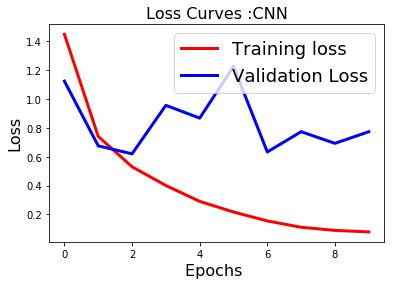

In [16]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

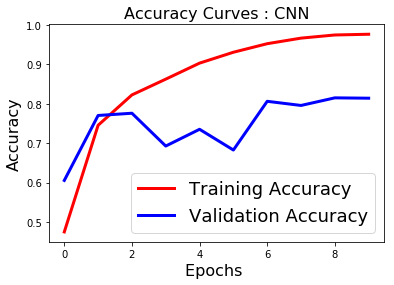

In [17]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()